In [138]:
import re
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [139]:
def extrair_jogos_relevantes(caminho_arquivo):
    jogos_relevantes = []

    with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
        for linha in arquivo:
            jogos_relevantes.append(linha.strip())

    return jogos_relevantes

In [140]:
def extrair_nomes_jogos(caminho_arquivo):
    nomes_jogos = []
    encontrou_midrule = False

    with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
        # Define um padrão de expressão regular para encontrar linhas que contenham nomes de jogos
        padrao = re.compile(r'\s*([^\n]+)\s*\\\\')

        for linha in arquivo:
            if '\\midrule' in linha:
                encontrou_midrule = True
                continue  # Pula para a próxima linha após encontrar \midrule

            if encontrou_midrule:
                # Tenta encontrar o padrão nas linhas do arquivo
                resultado = padrao.match(linha)
                if resultado:
                    # Adiciona o nome do jogo à lista
                    nome_jogo = resultado.group(1)
                    nomes_jogos.append(nome_jogo.strip())

    return nomes_jogos

In [141]:
def evaluate(results, relevant):
    precision_values = [
        round(
        len([
            doc 
            for doc in results[:idx]
            if doc in relevant
        ]) / idx, 2 )
        for idx, _ in enumerate(results, start=1)
    ]
    
    #print("Precision list: ", precision_values)
    
    recall_values = [
        round(
        len([
            doc for doc in results[:idx]
            if doc in relevant
        ]) / len(relevant), 2)
        for idx, _ in enumerate(results, start=1)
    ]
    
    #print("Recall list: ", recall_values)
    
    precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}
    
    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
    recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
    recall_values = sorted(set(recall_values))

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall_values):
        if step not in precision_recall_match:
            if recall_values[idx-1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
            else:
                precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]
    
        
    #print("Precision Recall Match:")
    #print(precision_recall_match)            
    
    tolerance = 0.0001  # adjust the tolerance as needed

    filtered_data = {round(key,1): value for key, value in precision_recall_match.items() if any(abs(key - allowed_key) < tolerance for allowed_key in np.arange(0.1, 1.1, 0.1))}
    filtered_data_sorted = dict(sorted(filtered_data.items()))
    return filtered_data_sorted
    

In [142]:
##QUERY 1
relevant_1 = extrair_jogos_relevantes('../queries/q1_2/q1_2_relevant.txt')
base1 = extrair_nomes_jogos('../queries/q1_2/q1_2_baseRank.txt')
boosted1 = extrair_nomes_jogos('../queries/q1_2/q1_2_boostedRank.txt')

##QUERY 2
relevant_2 = extrair_jogos_relevantes('../queries/q2_2/q2_2_relevant.txt')
base2 = extrair_nomes_jogos('../queries/q2_2/q2_2_baseRank.txt')
boosted2 = extrair_nomes_jogos('../queries/q2_2/q2_2_boostedRank.txt')

##QUERY 3
relevant_3 = extrair_jogos_relevantes('../queries/q3_2/q3_2_relevant.txt')
base3 = extrair_nomes_jogos('../queries/q3_2/q3_2_baseRank.txt')
boosted3 = extrair_nomes_jogos('../queries/q3_2/q3_2_boostedRank.txt')

##QUERY 4
relevant_4 = extrair_jogos_relevantes('../queries/q4_2/q4_2_relevant.txt')
base4 = extrair_nomes_jogos('../queries/q4_2/q4_2_baseRank.txt')
boosted4 = extrair_nomes_jogos('../queries/q4_2/q4_2_boostedRank.txt')

In [143]:
## Precision-Recall values

## Query1
pr_base1 = evaluate(base1, relevant_1)
pr_boosted1 = evaluate(boosted1, relevant_1)

## Query2
pr_base2 = evaluate(base2, relevant_2)
pr_boosted2 = evaluate(boosted2, relevant_2)

## Query3
pr_base3 = evaluate(base3, relevant_3)
pr_boosted3 = evaluate(boosted3, relevant_3)

## Query4
pr_base4 = evaluate(base4, relevant_4)
pr_boosted4 = evaluate(boosted4, relevant_4)

In [144]:
def interpolate(query_results):
    # Dicionário para armazenar a média para cada valor de recall
    media_por_recall = defaultdict(list)

    # Itera sobre os dicionários de resultados de diferentes queries
    for query_result in query_results:
        for recall, precision in query_result.items():
            media_por_recall[recall].append(precision)

    # Calcula a média para cada valor de recall
    media_por_recall = {recall: round(sum(precisions) / len(precisions), 2) for recall, precisions in media_por_recall.items()}

    return media_por_recall

In [145]:
query_results_base = [pr_base1, pr_base2, pr_base3, pr_base4]
query_results_boosted = [pr_boosted1, pr_boosted2, pr_boosted3, pr_boosted4]

pr_base = interpolate(query_results_base)
pr_boosted = interpolate(query_results_boosted)

print(pr_base)
print(pr_boosted)

{0.1: 0.96, 0.2: 0.96, 0.3: 0.92, 0.4: 0.93, 0.5: 0.93, 0.6: 0.88, 0.7: 0.87, 0.8: 0.87, 0.9: 0.85, 1.0: 0.85}
{0.1: 0.83, 0.2: 0.87, 0.3: 0.9, 0.4: 0.92, 0.5: 0.87, 0.6: 0.86, 0.7: 0.84, 0.8: 0.84, 0.9: 0.79, 1.0: 0.79}


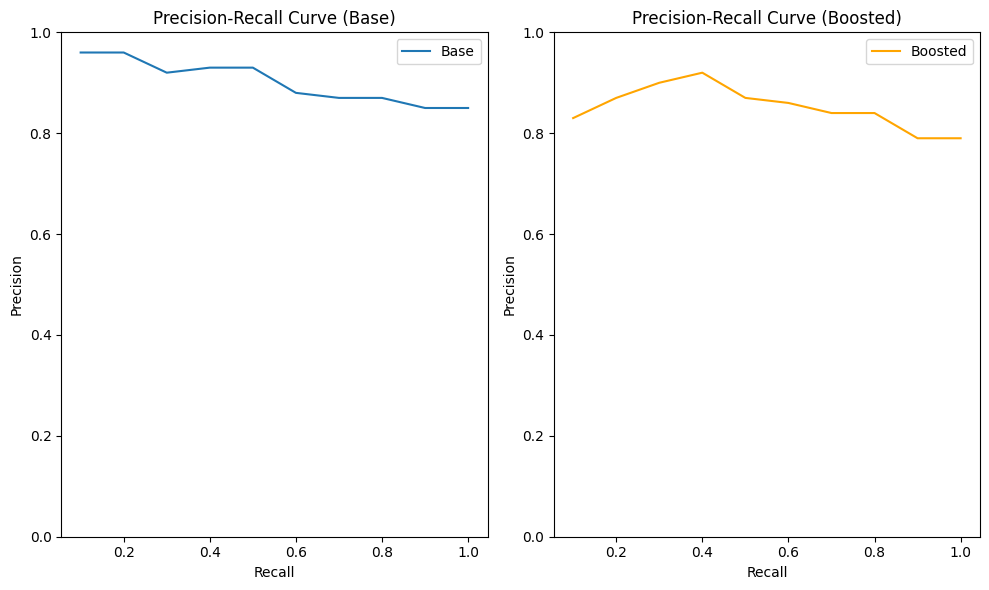

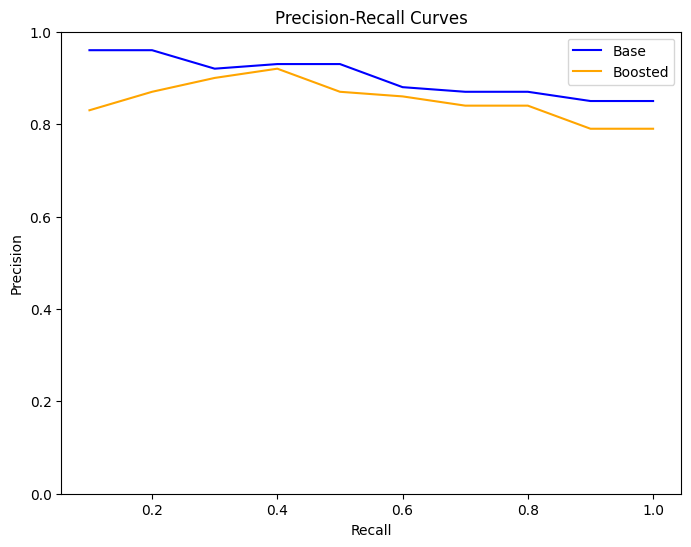

In [146]:
# Cria gráficos
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(list(pr_base.keys()), list(pr_base.values()), label='Base')
plt.title('Precision-Recall Curve (Base)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Define o limite y de 0 a 1
plt.legend()
plt.savefig('../queries/precision_recall_base_schema2.png')

plt.subplot(1, 2, 2)
plt.plot(list(pr_boosted.keys()), list(pr_boosted.values()), label='Boosted', color='orange')
plt.title('Precision-Recall Curve (Boosted)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Define o limite y de 0 a 1
plt.legend()
plt.savefig('../queries/precision_recall_boosted_schema2.png')

plt.tight_layout()
plt.show()

# Cria um gráfico único para ambas as curvas
plt.figure(figsize=(8, 6))

# Plota a curva da base
plt.plot(list(pr_base.keys()), list(pr_base.values()), label='Base', color='blue')

# Plota a curva da boosted
plt.plot(list(pr_boosted.keys()), list(pr_boosted.values()), label='Boosted', color='orange')

# Configurações do gráfico
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Define o limite y de 0 a 1
plt.legend()
plt.savefig('../queries/precision_recall_combined_schema2.png')

plt.show()